In [ ]:
# Copyright 2025 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# DWS on Vertex Training A100 and H100 GPU Demo

<table align="left">
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/generative-ai/blob/main/notebook_template.ipynb">
      <img width="32px" src="https://www.gstatic.com/pantheon/images/bigquery/welcome_page/colab-logo.svg" alt="Google Colaboratory logo"><br> Open in Colab
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/colab/import/https:%2F%2Fraw.githubusercontent.com%2FGoogleCloudPlatform%2Fgenerative-ai%2Fmain%2Fnotebook_template.ipynb">
      <img width="32px" src="https://lh3.googleusercontent.com/JmcxdQi-qOpctIvWKgPtrzZdJJK-J3sWE1RsfjZNwshCFgE_9fULcNpuXYTilIR2hjwN" alt="Google Cloud Colab Enterprise logo"><br> Open in Colab Enterprise
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/GoogleCloudPlatform/generative-ai/main/notebook_template.ipynb">
      <img src="https://www.gstatic.com/images/branding/gcpiconscolors/vertexai/v1/32px.svg" alt="Vertex AI logo"><br> Open in Vertex AI Workbench
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://github.com/GoogleCloudPlatform/generative-ai/blob/main/notebook_template.ipynb">
      <img width="32px" src="https://www.svgrepo.com/download/217753/github.svg" alt="GitHub logo"><br> View on GitHub
    </a>
  </td>
</table>

| Author(s) |
| --- |
| [Jose Brache](https://github.com/jbrache) |

## Overview

For custom training jobs that request GPU resources, Dynamic Workload Scheduler lets you schedule the jobs based on when the requested GPU resources become available. This page shows you how to schedule custom training jobs by using Dynamic Workload Scheduler, and how to customize the scheduling behavior on Vertex AI.

Review the public docs for the latest information on support: [Schedule training jobs based on resource availability](https://cloud.google.com/vertex-ai/docs/training/schedule-jobs-dws)

This example covers the following steps:
1. Setup a project
2. Create Test Training Code Container
3. Build/Push Custom Docker Container using Cloud Build
4. Prepare Training Job
5. Submit Training Job (A100 and H100 types)
6. Clean Up

### **<font color="grey">NOTE: THIS FEATURE WORKS FOR A100 and H100 MACHINE TYPES.</font>**

## Get started

### Install Vertex AI SDK and other required packages

In [2]:
# import sys

# if "google.colab" in sys.modules:
#     !pip3 install --upgrade google-cloud-aiplatform

#     # Restart the notebook kernel after installs.
#     import IPython

#     app = IPython.Application.instance()
#     app.kernel.do_shutdown(True)

---

#### ⚠️ Do not forget to click the "RESTART RUNTIME" button above.

---

If you install additional packages, it's suggested to restart the notebook kernel so it can find the packages.

### Authenticate your notebook environment (Colab only)

If you're running this notebook on Google Colab, run the cell below to authenticate your environment.

In [3]:
import sys

if "google.colab" in sys.modules:
    from google.colab import auth

    auth.authenticate_user()

# 0-0. Set Google Cloud project information

To get started using Vertex AI, you must have an existing Google Cloud project and [enable the Vertex AI API](https://console.cloud.google.com/flows/enableapi?apiid=aiplatform.googleapis.com).

Learn more about [setting up a project and a development environment](https://cloud.google.com/vertex-ai/docs/start/cloud-environment).

In [6]:
############## Set Project ###########################
# The project needs to be added to the allowlist by Vertex Training team
# before moving ahead to the rest of this Colab
PROJECT_ID= 'the-foo-bar' #@param {type:"string"}
REGION = 'us-central1' #@param {type:"string"}
BUCKET_URI = f'gs://{PROJECT_ID}-dws-jobs'

############ Setting the Enviroment ###########
SERVICE ="aiplatform.googleapis.com"
ENDPOINT="us-central1-aiplatform.googleapis.com"

In [8]:
!gcloud config set project $PROJECT_ID

Updated property [core/project].


## 0-1. Enable APIs
The following APIs are enabled in this demo:
1. [Enable the Vertex AI API](https://console.cloud.google.com/flows/enableapi?apiid=aiplatform.googleapis.com)
2. [Enable the Cloud Build API](https://console.cloud.google.com/flows/enableapi?apiid=cloudbuild.googleapis.com)
2. [Enable the Artifact Registry API](https://console.cloud.google.com/flows/enableapi?apiid=artifactregistry.googleapis.com): You must enable the Artifact Registry API for your project. You will store your custom training container in Artifact Registry. [Learn more about Enabling the Artifact Registry service](https://cloud.google.com/artifact-registry/docs/enable-service)


In [19]:
############# Enable the APIs ########################
!gcloud services enable aiplatform.googleapis.com artifactregistry.googleapis.com cloudbuild.googleapis.com

# print('You may go to the below uri and to ensure the API is enabled.')
# print('https://console.cloud.google.com/apis/library/{}?project={}'.format(SERVICE, PROJECT_ID))

You may go to the below uri and to ensure the API is enabled.
https://console.cloud.google.com/apis/library/aiplatform.googleapis.com?project=the-foo-bar


## 0-2. Import libraries

In [5]:
import json
import logging
import traceback
import sys
import os

## 0-3. Create a Cloud Storage bucket

Create a storage bucket to store intermediate artifacts such as datasets.

**Only if your bucket doesn't already exist**: Run the following cell to create your Cloud Storage bucket.

In [21]:
create_bucket = False
if create_bucket:
    !gsutil mb -l $REGION -p $PROJECT_ID $BUCKET_URI

## 0-3. Training Code Container

In [22]:
CONTAINER_DIR = "gpu_container"

In [23]:
!mkdir -p $CONTAINER_DIR/trainer
!touch $CONTAINER_DIR/trainer/train.py

In [24]:
%%writefile $CONTAINER_DIR/trainer/train.py
import argparse
import logging
import sys
import os
import time
import json

# PyTorch imports
import torch

def parse_args():
  """Parses command-line arguments."""
  """Argument parser.

  Returns:
    Dictionary of arguments.
  """
  parser = argparse.ArgumentParser()

  parser.add_argument('--log-level', help='Logging level.', choices=['DEBUG', 'ERROR', 'FATAL', 'INFO', 'WARN'], default='INFO')
  parser.add_argument('--sleep', help='Logging level.', type=str, default='600s')
  parsed, unknown = parser.parse_known_args() # this is an 'internal' method
  return parsed, unknown

if __name__ == '__main__':
  """Entry point"""
  arguments, unknown_args = parse_args()
  logging.basicConfig(level=arguments.log_level)

  if arguments.sleep[-1] == "s":
    sleep = int(arguments.sleep[:-1])
  else:
    sleep = int(arguments.sleep)

  try:
    logging.info(torch.__version__)
    logging.info(torch.cuda.get_device_properties(0))
    logging.info(torch.randn(1, device="cuda"))
  except Exception as err:
    logging.info(err)
    logging.info(f"Unexpected {err=}, {type(err)=}")

  # Sleeping 600 seconds to connect the web shell
  logging.info(f'Sleeping for {sleep} seconds...')
  time.sleep(sleep)

Overwriting gpu_container/trainer/train.py


- [built container similar to this](https://github.com/usegalaxy-eu/gpu-jupyterlab-docker/blob/main/Dockerfile)
- [nvidia/cuda docker images](https://hub.docker.com/r/nvidia/cuda/tags?page=1&name=12.2.)

In [25]:
# @title Dockerfile
%%writefile $CONTAINER_DIR/Dockerfile
FROM nvidia/cuda:12.4.1-cudnn-runtime-ubuntu22.04
WORKDIR /root

# Version of python to be installed and used
ENV PYTHON_VERSION=3.10

ENV DEBIAN_FRONTEND noninteractive

RUN apt-get update
RUN apt-get install -y telnet netcat iputils-ping  net-tools
RUN apt-get update && \
    apt-get install -y software-properties-common && \
    add-apt-repository -y ppa:deadsnakes/ppa && \
    apt-get update && \
    apt install -y python$PYTHON_VERSION python$PYTHON_VERSION-dev python3-pip python$PYTHON_VERSION-distutils && \
    apt-get clean && rm -rf /var/lib/apt/lists/*

RUN python$PYTHON_VERSION --version
RUN ln -fs /usr/bin/python$PYTHON_VERSION /usr/bin/python

# -----------------------------------------------------
# Install pip packages
# https://pytorch.org/get-started/previous-versions/
# https://github.com/pytorch/pytorch/blob/main/RELEASE.md#release-compatibility-matrix
# Pytorch 2.* with CUDA 12.4
# pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124

RUN python$PYTHON_VERSION -m pip install \
    torch \
    torchvision \
    torchaudio \
    --index-url https://download.pytorch.org/whl/cu124 && \
    rm -r ~/.cache/pip
# -----------------------------------------------------

# Copies the trainer code
RUN mkdir /root/trainer
COPY trainer/train.py /root/trainer/train.py

# Sets up the entry point to invoke the trainer.
# ENTRYPOINT ["python3", "trainer/train.py"]
ENTRYPOINT "python$PYTHON_VERSION" trainer/train.py

Overwriting gpu_container/Dockerfile


In [26]:
%%writefile $CONTAINER_DIR/requirements.txt

Overwriting gpu_container/requirements.txt


In [27]:
# Print the location where the training code exists, will be used to create the artifact registry container
print(f"Local container directory with training code: {CONTAINER_DIR}")
print("Check whether the container directory exists:", os.path.exists(CONTAINER_DIR))

Local container directory with training code: gpu_container
Check whether the container directory exists: True


In [28]:
# Repo to create / use for running training job
PRIVATE_REPO = "gpu-training"
TRAIN_IMAGE = (
    f"{REGION}-docker.pkg.dev/" + PROJECT_ID + f"/{PRIVATE_REPO}" + "/gpu-pytorch-training-test:latest"
)
print("Private Repo:", PRIVATE_REPO)
print("Training Container Image:", TRAIN_IMAGE)

Private Repo: gpu-training
Training Container Image: us-central1-docker.pkg.dev/the-foo-bar/gpu-training/gpu-pytorch-training-test:latest


# 1-0. Build and Push Custom Container to Artifact Registry

You must have enabled the Artifact Registry API for your project in the previous steps. You will store your custom training container in Artifact Registry.

### Create a private Docker repository
Your first step is to create a Docker repository in Artifact Registry.

1 - Run the `gcloud artifacts repositories create` command to create a new Docker repository with your region with the description `docker repository`.

2 - Run the `gcloud artifacts repositories list` command to verify that your repository was created.

In [34]:
# Repo to create / use for running training job
PRIVATE_REPO = "gpu-training"
TRAIN_IMAGE = (
    f"{REGION}-docker.pkg.dev/" + PROJECT_ID + f"/{PRIVATE_REPO}" + "/gpu-pytorch-training-test:latest"
)

print("Private Repo:", PRIVATE_REPO)
print("Deployment:", TRAIN_IMAGE)

Private Repo: gpu-training
Deployment: us-central1-docker.pkg.dev/the-foo-bar/gpu-training/gpu-pytorch-training-test:latest


In [ ]:
!gcloud artifacts repositories create {PRIVATE_REPO} --repository-format=docker --project={PROJECT_ID} --location={REGION} --description="Docker repository"

Create request issued for: [gpu-training]
Created repository [gpu-training].


In [35]:
!gcloud artifacts repositories --project={PROJECT_ID} list

Listing items under project the-foo-bar, across all locations.

                                                                                                                                ARTIFACT_REGISTRY
REPOSITORY                           FORMAT  MODE                 DESCRIPTION                                                                                 LOCATION     LABELS                          ENCRYPTION          CREATE_TIME          UPDATE_TIME          SIZE (MB)
cloud-run-source-deploy              DOCKER  STANDARD_REPOSITORY  Cloud Run Source Deployments                                                                us-central1                                  Google-managed key  2024-03-31T23:46:18  2024-08-13T21:06:59  6011.228
gcf-artifacts                        DOCKER  STANDARD_REPOSITORY  This repository is created and used by Cloud Functions for storing function docker images.  us-central1  goog-managed-by=cloudfunctions  Google-managed key  2023-05-06T18:26:3

## 2-1. Build and push the custom docker container image by using Cloud Build

Build and push a Docker image with Cloud Build

In [36]:
!cd $CONTAINER_DIR && gcloud builds submit --timeout=1800s --project={PROJECT_ID} --region={REGION} --tag $TRAIN_IMAGE

Creating temporary archive of 3 file(s) totalling 2.6 KiB before compression.
Uploading tarball of [.] to [gs://the-foo-bar_cloudbuild/source/1743006351.804199-7a62a655789d4d61bfc238199bf0c0a1.tgz]
Created [https://cloudbuild.googleapis.com/v1/projects/the-foo-bar/locations/us-central1/builds/f951f5ff-8cae-46a9-9470-e51a722ea736].
Logs are available at [ https://console.cloud.google.com/cloud-build/builds;region=us-central1/f951f5ff-8cae-46a9-9470-e51a722ea736?project=367134663675 ].
Waiting for build to complete. Polling interval: 1 second(s).
 REMOTE BUILD OUTPUT
starting build "f951f5ff-8cae-46a9-9470-e51a722ea736"

FETCHSOURCE
Fetching storage object: gs://the-foo-bar_cloudbuild/source/1743006351.804199-7a62a655789d4d61bfc238199bf0c0a1.tgz#1743006352346841
Copying gs://the-foo-bar_cloudbuild/source/1743006351.804199-7a62a655789d4d61bfc238199bf0c0a1.tgz#1743006352346841...
/ [1 files][  1.5 KiB/  1.5 KiB]                                                
Operation completed over 1 obj

# 2-0. Prepare training jobs

We support submiting custom training job with prebuilt container, custom container and python application via **HTTP request, Vertex AI SDK or gcloud CLI**. Learn more [here](https://cloud.google.com/vertex-ai/docs/training/code-requirements)

In this example, we will demonstrate how to run custom job with with custom container. Please specify the images below to your custom images.
Note, if it's not a public image, please ensure it's already pushed to your project.

https://cloud.google.com/vertex-ai/docs/training/containers-overview

## 2-1. A100 DWS training job config

In [37]:
# Define training Customer Container URI
PRIVATE_REPO = "gpu-training"
TRAIN_IMAGE = (
    f"{REGION}-docker.pkg.dev/" + PROJECT_ID + f"/{PRIVATE_REPO}" + "/gpu-pytorch-training-test:latest"
)

GPU_IMAGE = TRAIN_IMAGE
JOB_DIR = BUCKET_URI
print("Using image: ", GPU_IMAGE)
print("Output Model Directory: ", JOB_DIR)

Using image:  us-central1-docker.pkg.dev/the-foo-bar/gpu-training/gpu-pytorch-training-test:latest
Output Model Directory:  gs://the-foo-bar-dws-jobs


In [31]:
# @title A100 Machine Spec Definition
############ Set Resource Pool Spec #####################
#
# Edit the cluster config below if you want.
#
# Note that, if you specify any GPU pool, please ensure that the machine type
# is compatible with the accelerator type, for example, A100 GPU can only work
# on A2 machine types.
# See more detalis in https://cloud.google.com/compute/docs/gpus#nvidia_gpus_for_compute_workloads

# GPU_MACHINE_TYPE =  "a2-highgpu-8g" #@param {type:"string"}
# GPU_REPLICA_COUNT = 1 # @param {type:"integer"}
# ACCELERATOR_TYPE = "NVIDIA_TESLA_A100"
# GPU_ACCELERATOR_COUNT = 8

GPU_MACHINE_TYPE =  "a2-highgpu-1g" #@param {type:"string"}
GPU_REPLICA_COUNT = 1 # @param {type:"integer"}
ACCELERATOR_TYPE = "NVIDIA_TESLA_A100"
GPU_ACCELERATOR_COUNT = 1

The CustomJobSpec has these optional [scheduling](https://cloud.google.com/vertex-ai/docs/reference/rest/v1/CustomJobSpec#scheduling) options.

Pass `maxWaitDuration`, by default the wait time is 1 day.

In [38]:
############ Set WorkerPool Spec #####################
# https://cloud.google.com/sdk/gcloud/reference/beta/ai/custom-jobs/create
CONTENT=f"""
workerPoolSpecs:
  - machineSpec:
      machineType: {GPU_MACHINE_TYPE}
      acceleratorType: {ACCELERATOR_TYPE}
      acceleratorCount: {GPU_ACCELERATOR_COUNT}
    replicaCount: {GPU_REPLICA_COUNT}
    containerSpec:
      imageUri: {GPU_IMAGE}
      args:
scheduling:
  strategy: FLEX_START
  maxWaitDuration: 1800s
"""

In [39]:
f = open("a100_custom_job_spec.yaml", "w")
f.write(CONTENT[1:])
f.close()

!cat a100_custom_job_spec.yaml

workerPoolSpecs:
  - machineSpec:
      machineType: a2-highgpu-1g
      acceleratorType: NVIDIA_TESLA_A100
      acceleratorCount: 1
    replicaCount: 1
    containerSpec:
      imageUri: us-central1-docker.pkg.dev/the-foo-bar/gpu-training/gpu-pytorch-training-test:latest
      args:
scheduling:
  strategy: FLEX_START
  maxWaitDuration: 1800s


#### Create A100 job on Vertex AI Training

In [40]:
### Create A Single GPU node Training Job
!gcloud beta ai custom-jobs create \
    --project={PROJECT_ID} \
    --region={REGION} \
    --display-name="A100 GPU Test Job" \
    --config=a100_custom_job_spec.yaml \
    --enable-web-access \
    --labels dws_job=true

Using endpoint [https://us-central1-aiplatform.googleapis.com/]
CustomJob [projects/367134663675/locations/us-central1/customJobs/8400782600196587520] is submitted successfully.

Your job is still active. You may view the status of your job with the command

  $ gcloud beta ai custom-jobs describe projects/367134663675/locations/us-central1/customJobs/8400782600196587520

or continue streaming the logs with the command

  $ gcloud beta ai custom-jobs stream-logs projects/367134663675/locations/us-central1/customJobs/8400782600196587520


This was captured using the web-access shell in the job, **Vertex aI Training job**:

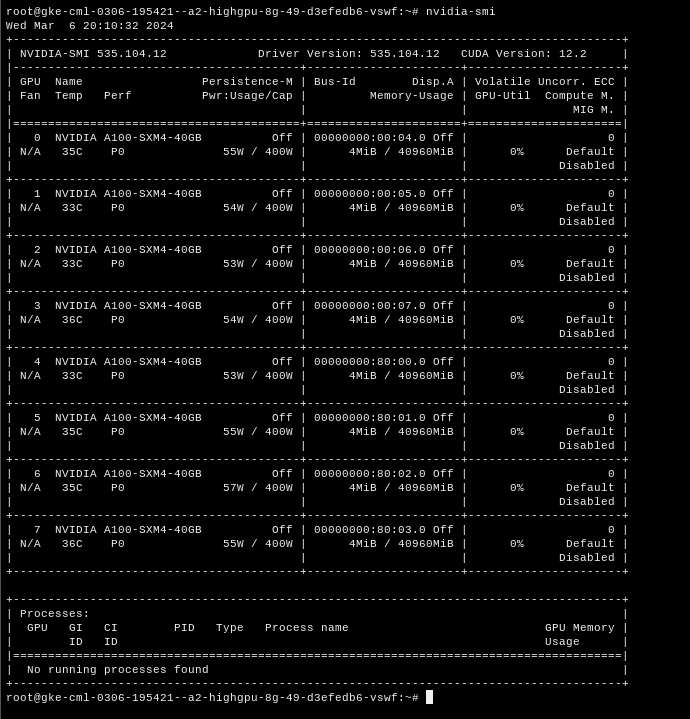

## 2-2. H100 DWS training job config

In [41]:
# @title H100 Machine Spec Definition
############ Set Resource Pool Spec #####################
#
# Edit the cluster config below if you want.
#
# Note that, if you specify any GPU pool, please ensure that the machine type
# is compatible with the accelerator type, for example, A100 GPU can only work
# on A2 machine types.
# See more detalis in https://cloud.google.com/compute/docs/gpus#nvidia_gpus_for_compute_workloads

GPU_MACHINE_TYPE =  "a3-highgpu-8g" #@param {type:"string"}
GPU_REPLICA_COUNT = 1 # @param {type:"integer"}
ACCELERATOR_TYPE = "NVIDIA_H100_80GB"
GPU_ACCELERATOR_COUNT = 8

The CustomJobSpec has these optional [scheduling](https://cloud.google.com/vertex-ai/docs/reference/rest/v1/CustomJobSpec#scheduling) options.

Pass `maxWaitDuration`, by default the wait time is 1 day.

In [42]:
############ Set WorkerPool Spec #####################
# https://cloud.google.com/sdk/gcloud/reference/beta/ai/custom-jobs/create
CONTENT=f"""
workerPoolSpecs:
  - machineSpec:
      machineType: {GPU_MACHINE_TYPE}
      acceleratorType: {ACCELERATOR_TYPE}
      acceleratorCount: {GPU_ACCELERATOR_COUNT}
    replicaCount: {GPU_REPLICA_COUNT}
    containerSpec:
      imageUri: {GPU_IMAGE}
      args:
scheduling:
  strategy: FLEX_START
  maxWaitDuration: 1800s
"""

In [43]:
f = open("h100_custom_job_spec.yaml", "w")
f.write(CONTENT[1:])
f.close()

!cat h100_custom_job_spec.yaml

workerPoolSpecs:
  - machineSpec:
      machineType: a3-highgpu-8g
      acceleratorType: NVIDIA_H100_80GB
      acceleratorCount: 8
    replicaCount: 1
    containerSpec:
      imageUri: us-central1-docker.pkg.dev/the-foo-bar/gpu-training/gpu-pytorch-training-test:latest
      args:
scheduling:
  strategy: FLEX_START
  maxWaitDuration: 1800s


#### Create H100 job on Vertex AI Training

In [44]:
### Create A Single GPU node Training Job
!gcloud beta ai custom-jobs create \
    --project={PROJECT_ID} \
    --region={REGION} \
    --display-name="H100 GPU Test Job" \
    --config=h100_custom_job_spec.yaml \
    --enable-web-access \
    --labels dws_job=true

Using endpoint [https://us-central1-aiplatform.googleapis.com/]
CustomJob [projects/367134663675/locations/us-central1/customJobs/4255993199388000256] is submitted successfully.

Your job is still active. You may view the status of your job with the command

  $ gcloud beta ai custom-jobs describe projects/367134663675/locations/us-central1/customJobs/4255993199388000256

or continue streaming the logs with the command

  $ gcloud beta ai custom-jobs stream-logs projects/367134663675/locations/us-central1/customJobs/4255993199388000256


This was captured using the web-access shell in the job, **Vertex aI Training job**:

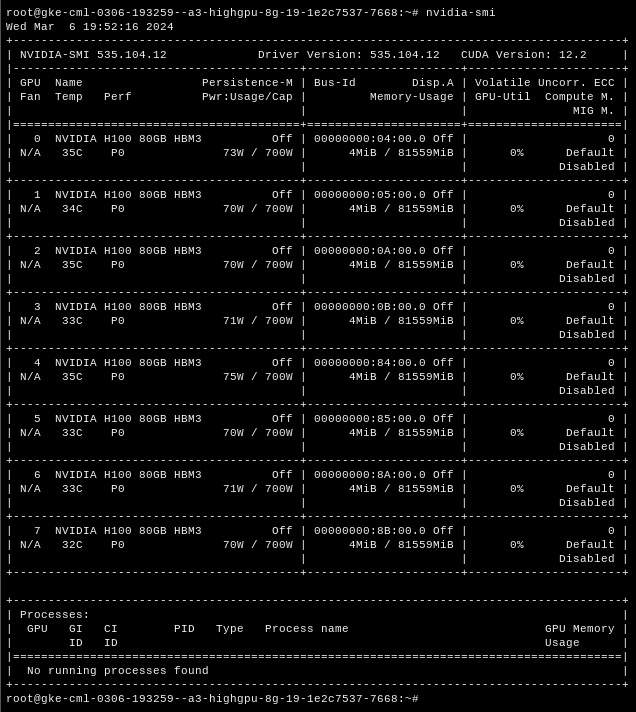

# 3-0 Get Job Details

In [45]:
# Option 1: Use the Custom Job ID to get details
# JOB_ID = "" # @param {type:"string"}
# !gcloud beta ai custom-jobs describe {JOB_ID} --project={PROJECT_ID} --region={REGION}

In [46]:
# Option 2: List existing custom jobs, filter running jobs and ones with the set label
# Lists the existing custom jobs, filters with the label set for these jobs
FILTER='"(state!="JOB_STATE_SUCCEEDED" AND state!="JOB_STATE_FAILED" AND state!="JOB_STATE_CANCELLED") AND labels.dws_job=true"'
!gcloud beta ai custom-jobs list --project={PROJECT_ID} --region={REGION} --filter={FILTER}

Using endpoint [https://us-central1-aiplatform.googleapis.com/]
---
createTime: '2025-03-26T16:44:01.317948Z'
displayName: A100 GPU Test Job
jobSpec:
  enableWebAccess: true
  scheduling:
    maxWaitDuration: 1800s
    strategy: FLEX_START
  workerPoolSpecs:
  - containerSpec:
      imageUri: us-central1-docker.pkg.dev/the-foo-bar/gpu-training/gpu-pytorch-training-test:latest
    diskSpec:
      bootDiskSizeGb: 100
      bootDiskType: pd-ssd
    machineSpec:
      acceleratorCount: 1
      acceleratorType: NVIDIA_TESLA_A100
      machineType: a2-highgpu-1g
    replicaCount: '1'
labels:
  dws_job: 'true'
name: projects/367134663675/locations/us-central1/customJobs/8400782600196587520
startTime: '2025-03-26T16:44:01.579664Z'
state: JOB_STATE_PENDING
updateTime: '2025-03-26T16:49:55.901616Z'
---
createTime: '2025-03-26T16:49:18.656865Z'
displayName: H100 GPU Test Job
jobSpec:
  enableWebAccess: true
  scheduling:
    maxWaitDuration: 1800s
    strategy: FLEX_START
  workerPoolSpecs:
  - c

# 4-0. Cleaning up

To clean up all Google Cloud resources used in this project, you can [delete the Google Cloud
project](https://cloud.google.com/resource-manager/docs/creating-managing-projects#shutting_down_projects) you used for the tutorial.

Otherwise, you can delete the individual resources you created in this tutorial:

- Cloud Storage Bucket
- Artifacts Repository

In [ ]:
# Set this to true only if you'd like to delete your bucket
delete_bucket = False
delete_artifacts_repo = False

if delete_bucket:
  !gsutil rm -rf $JOB_DIR
  !gsutil rm -r $BUCKET_URI

if delete_artifacts_repo:
  !gcloud artifacts repositories delete {PRIVATE_REPO} --project={PROJECT_ID} --location={REGION} --quiet

Using endpoint [https://us-central1-aiplatform.googleapis.com/]
Request to delete the PersistentResource [projects/jbrache-llm/locations/us-central1/persistentResources/preview-pr-gpu-gcloud-1] has been sent.

You may view the status of your persistent resource with the command

  $ gcloud beta ai persistent-resources describe projects/jbrache-llm/locations/us-central1/persistentResources/preview-pr-gpu-gcloud-1

